In [205]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\This PC\OneDrive\OneDrive - Islamabad Model Postgraduate College of Commerce H-8 4 Islamabad\SZABIST WORKING ZONE\SZABIST WORKING S 4\DATASETS\HouseHould Power Consumption\household_power_consumption.csv")

# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Drop rows with invalid datetime values
df = df.dropna(subset=['Datetime'])

# Set Datetime as index
df.set_index('Datetime', inplace=True)

# Convert necessary columns to numeric (coerce errors to NaN)
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage',
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Optional: drop missing values for simplicity
df = df.dropna()


C:\Users\This PC\AppData\Local\Temp\ipykernel_21028\3122019957.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044506 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1044506 non-null  object 
 1   Time                   1044506 non-null  object 
 2   Global_active_power    1044506 non-null  float64
 3   Global_reactive_power  1044506 non-null  float64
 4   Voltage                1044506 non-null  float64
 5   Global_intensity       1044506 non-null  float64
 6   Sub_metering_1         1044506 non-null  float64
 7   Sub_metering_2         1044506 non-null  float64
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(7), object(2)
memory usage: 79.7+ MB


In [167]:
df.describe()

,Sub_metering_3
count,1.044506e+06
mean,5.933837e+00
std,8.210398e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.700000e+01
max,3.100000e+01


Removing Duplicates and Null Data


In [209]:
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [210]:
df=df.dropna()

In [211]:
import numpy as np

In [212]:
df.duplicated().sum()

0

In [213]:
df=df.drop_duplicates()

In [219]:
df.shape

(1044506, 9)

In [223]:
# Resample data to hourly mean
hourly_df = df['Global_active_power'].resample('H').mean()


C:\Users\This PC\AppData\Local\Temp\ipykernel_21028\3111150548.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df['Global_active_power'].resample('H').mean()


In [225]:
# Reset index to extract datetime features
hourly_df = hourly_df.reset_index()
hourly_df['hour'] = hourly_df['Datetime'].dt.hour
hourly_df['dayofweek'] = hourly_df['Datetime'].dt.dayofweek
hourly_df['is_weekend'] = hourly_df['dayofweek'] >= 5


In [227]:
# Use 80% for training, 20% for testing
train_size = int(len(hourly_df) * 0.8)
train = hourly_df[:train_size]
test = hourly_df[train_size:]


In [229]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Fit ARIMA model (simple example, no parameter tuning)
model = ARIMA(train['Global_active_power'], order=(5,1,0))
model_fit = model.fit()

# Forecast
forecast_arima = model_fit.forecast(steps=len(test))

# Evaluation
mae_arima = mean_absolute_error(test['Global_active_power'], forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test['Global_active_power'], forecast_arima))


In [231]:
from prophet import Prophet

# Prepare data
prophet_df = train[['Datetime', 'Global_active_power']].rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})

# Fit model
prophet = Prophet()
prophet.fit(prophet_df)

# Make future dataframe
future = prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = prophet.predict(future)

# Extract forecast
predicted_prophet = forecast_prophet.iloc[-len(test):]['yhat'].values

# Evaluation
mae_prophet = mean_absolute_error(test['Global_active_power'], predicted_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test['Global_active_power'], predicted_prophet))


20:52:33 - cmdstanpy - INFO - Chain [1] start processing
20:52:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\This PC\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [233]:
from xgboost import XGBRegressor

# Create lag features
for lag in range(1, 25):
    hourly_df[f'lag_{lag}'] = hourly_df['Global_active_power'].shift(lag)

# Drop NA rows caused by lagging
hourly_df.dropna(inplace=True)

# Re-split after lagging
X = hourly_df.drop(['Datetime', 'Global_active_power'], axis=1)
y = hourly_df['Global_active_power']
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Predict
predicted_xgb = xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, predicted_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predicted_xgb))


C:\Users\This PC\AppData\Local\Temp\ipykernel_21028\2326197083.py:43: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from current font.
  plt.tight_layout()
C:\Users\This PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


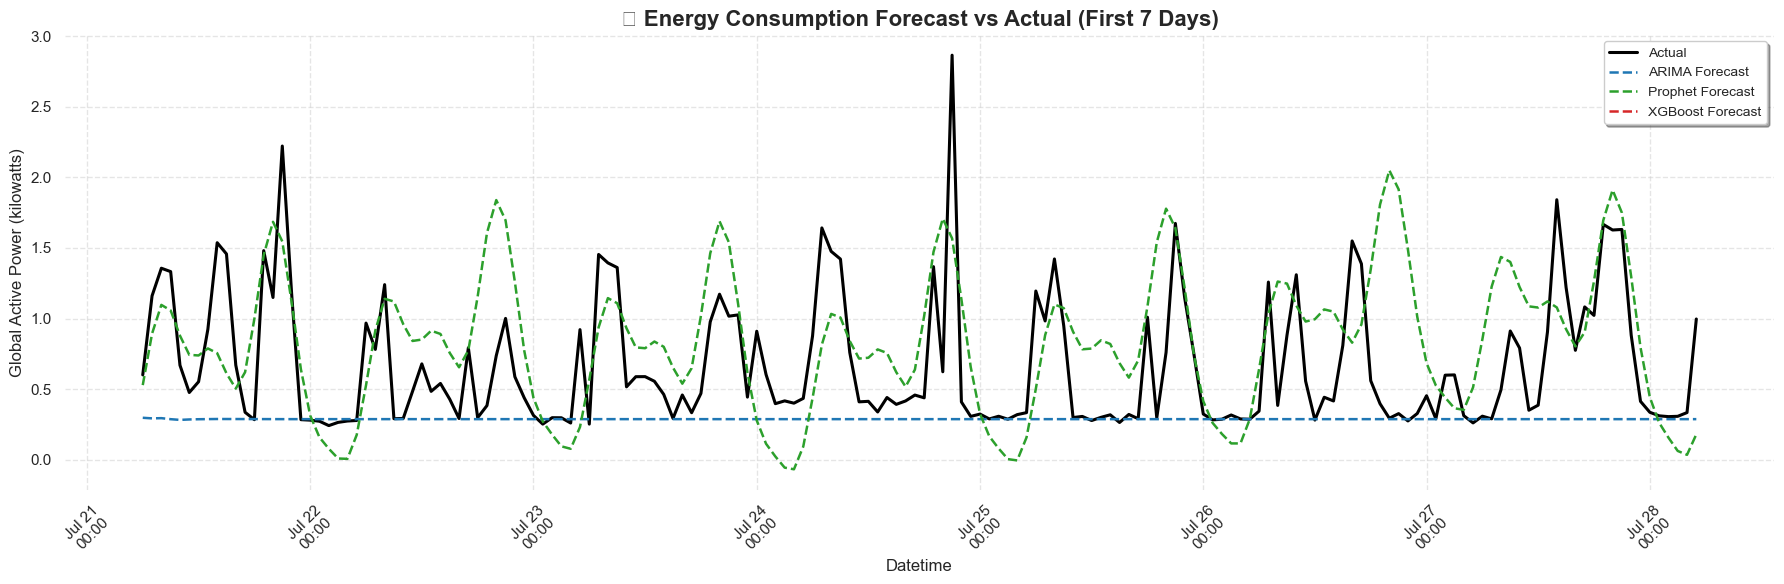

In [245]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

# Set Seaborn theme for professional look
sns.set_theme(style="whitegrid")

# Prepare data (same as before)
plot_df = test[['Datetime', 'Global_active_power']].copy()
plot_df['ARIMA'] = forecast_arima.values
plot_df['Prophet'] = predicted_prophet
plot_df.set_index('Datetime', inplace=True)

xgb_plot = pd.DataFrame({'XGBoost': predicted_xgb}, index=X_test.index)
plot_df = plot_df.join(xgb_plot, how='left')

# Zoom to first 7 days
plot_zoom = plot_df.iloc[:24*7]

# Plotting
plt.figure(figsize=(18, 6))

# Plot each line
plt.plot(plot_zoom.index, plot_zoom['Global_active_power'], label='Actual', color='black', linewidth=2.2)
plt.plot(plot_zoom.index, plot_zoom['ARIMA'], label='ARIMA Forecast', linestyle='--', color='#1f77b4', linewidth=1.8)
plt.plot(plot_zoom.index, plot_zoom['Prophet'], label='Prophet Forecast', linestyle='--', color='#2ca02c', linewidth=1.8)
plt.plot(plot_zoom.index, plot_zoom['XGBoost'], label='XGBoost Forecast', linestyle='--', color='#d62728', linewidth=1.8)

# Title and labels
plt.title("🔌 Energy Consumption Forecast vs Actual (First 7 Days)", fontsize=16, fontweight='bold')
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Global Active Power (kilowatts)", fontsize=12)

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
plt.xticks(rotation=45)

# Add legend
plt.legend(fontsize=10, frameon=True, shadow=True)

# Final polish
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.box(False)

# Show plot
plt.show()


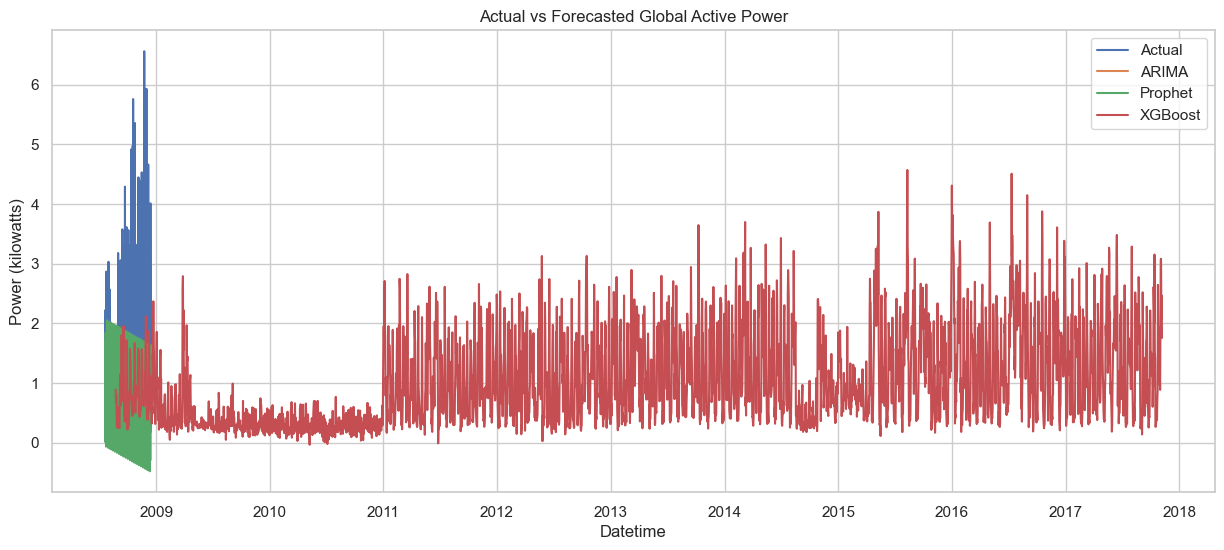

In [247]:
plt.figure(figsize=(15, 6))
plt.plot(test['Datetime'], test['Global_active_power'], label='Actual')
plt.plot(test['Datetime'], forecast_arima, label='ARIMA')
plt.plot(test['Datetime'], predicted_prophet, label='Prophet')
plt.plot(X_test.index, predicted_xgb, label='XGBoost')  # ✅ Fixed line
plt.legend()
plt.title("Actual vs Forecasted Global Active Power")
plt.xlabel("Datetime")
plt.ylabel("Power (kilowatts)")
plt.show()


In [237]:
print(f"ARIMA: MAE={mae_arima:.4f}, RMSE={rmse_arima:.4f}")
print(f"Prophet: MAE={mae_prophet:.4f}, RMSE={rmse_prophet:.4f}")
print(f"XGBoost: MAE={mae_xgb:.4f}, RMSE={rmse_xgb:.4f}")


ARIMA: MAE=0.7127, RMSE=1.1195
Prophet: MAE=0.7071, RMSE=0.9415
XGBoost: MAE=0.3499, RMSE=0.5271
